<a href="https://colab.research.google.com/github/kevinzakka/clip_playground/blob/main/CLIP_reCAPTCHA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP reCAPTCHA Solve

This Colab notebook demos zero-shot reCAPTCHA solving using CLIP + patch detection.

In [1]:
#@title Install dependencies

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

%%capture
!pip install ftfy regex tqdm matplotlib bs4
!pip install git+https://github.com/openai/CLIP.git

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import urllib.request
import matplotlib.pyplot as plt
import clip
from PIL import Image
from torchvision import transforms
from bs4 import BeautifulSoup

In [2]:
#@title Helper functions

#@markdown Some helper functions for loading, patchifying and visualizing images.

def load_image(img_path, resize=None, pil=False):
    image = Image.open(image_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    if pil:
        return image
    image = np.asarray(image).astype(np.float32) / 255.
    return image

def viz_patches(x, figsize=(20, 20), patch_idx=None, topk=None, t=5):
    # x: num_patches, 3, patch_size, patch_size
    n = x.shape[0]
    nrows = int(math.sqrt(n))
    fig, axes = plt.subplots(nrows, nrows, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):            
        im = x[i].permute(1, 2, 0).numpy()
        im = (im * 255.).round().astype(np.uint8)
        if patch_idx is not None and i == patch_idx:
            im[0:t] = (255, 0, 0)
            im[im.shape[0]-t:] = (255, 0, 0)
            im[:, 0:t] = (255, 0, 0)
            im[:, im.shape[1]-t:] = (255, 0, 0)
        if topk is not None:
            if i in topk and i != patch_idx:
                im[0:t] = (255, 255, 0)
                im[im.shape[0]-t:] = (255, 255, 0)
                im[:, 0:t] = (255, 255, 0)
                im[:, im.shape[1]-t:] = (255, 255, 0)
        ax.imshow(im)
        ax.axis("off")
    plt.show()

def patchify(image_path, resolution, patch_size, patch_stride=None, resize=None):
    img_tensor = torch.from_numpy(load_image(image_path, resolution)).permute(2, 0, 1)
    if patch_stride is None:
        patch_stride = patch_size
    patches = img_tensor.unfold(
        1, patch_size, patch_stride).unfold(2, patch_size, patch_stride)
    patches = patches.reshape(3, -1, patch_size, patch_size).permute(1, 0, 2, 3)
    if resize is not None:
        patches = F.interpolate(
            patches,
            (resize, resize),
            mode='bicubic',
            align_corners=False)
    return patches  # N, 3, patch_size, patch_size

Captcha Image Resolution: (300, 300, 3)


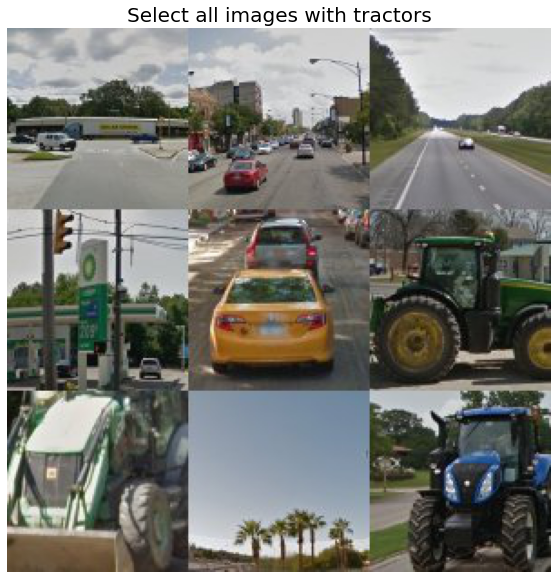

In [3]:
#@title Query reCAPTCHA API

#@markdown You might have to click the *Play* button more than once if the URL
#@markdown returns a 404.

URL = "https://www.google.com/recaptcha/api/fallback?k=6LewPtQSAAAAAIvk6kmw1mVSYVUvd2Ev5MpenlHk"
url_contents = urllib.request.urlopen(URL).read()
soup = BeautifulSoup(url_contents, "html")
instruction = soup.find("div", {"class": "rc-imageselect-desc-no-canonical"}).get_text()
caption = instruction.split(' ')[-1]
image = soup.find("img", {"class": "fbc-imageselect-payload"})
image_url = f"https://www.google.com/{image['src']}"
image_path = 'image.png'
urllib.request.urlretrieve(image_url, image_path)

image_np = load_image(image_path)
print(f"Captcha Image Resolution: {image_np.shape}")
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.title(instruction, fontsize=20)
plt.axis("off")
plt.show()

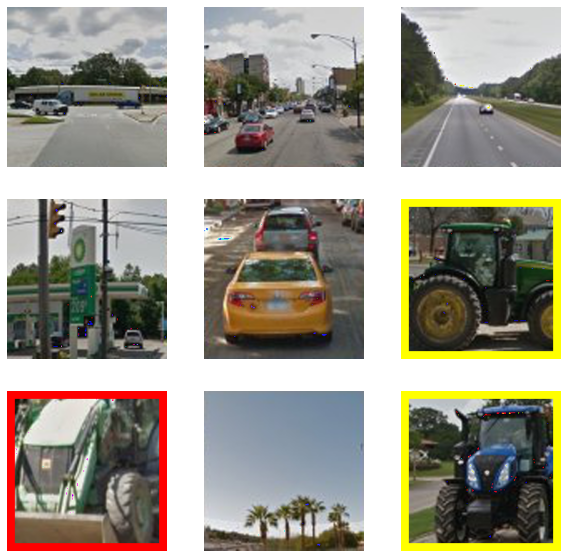

In [4]:
#@title Solve

clip_model = "ViT-B/16" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/32", "ViT-B/16"]
topk =  3#@param {type:"integer"}

# Load CLIP model.
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

patch_size = model.visual.input_resolution
patches = patchify(image_path, 300, 100, resize=model.visual.input_resolution).to(device)
text_input = clip.tokenize([instruction]).to(device)

with torch.no_grad():
    patches_norm = transforms.Normalize(
        (0.48145466, 0.4578275, 0.40821073),
        (0.26862954, 0.26130258, 0.27577711),
    )(patches)
    patch_embs = model.encode_image(patches_norm).float()
    text_embs = model.encode_text(text_input).float()
    patch_embs = patch_embs / patch_embs.norm(dim=-1, keepdim=True)
    text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)
    sim = patch_embs @ text_embs.t()
    idx_max = sim.argmax().item()
    topk_values, topk_idxs = torch.topk(sim.flatten(), topk)
    topk_idxs = topk_idxs.cpu().numpy().tolist()

viz_patches(patches.cpu(), figsize=(10, 10), patch_idx=idx_max, topk=topk_idxs, t=int(0.05*patch_size))